In [1]:
from torch import nn
import torch
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import os
import anndata
import math
import hnswlib

from modules import network,mlp,contrastive_loss
from utils import yaml_config_hook,save_model
from evaluation import evaluation_tools

import warnings
warnings.filterwarnings("ignore")

In [2]:
parser = argparse.ArgumentParser()
config = yaml_config_hook("config/config.yaml")
for k, v in config.items():
    parser.add_argument(f"--{k}", default=v, type=type(v))
args = parser.parse_args([])
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

# torch.manual_seed(args.seed)
# torch.cuda.manual_seed_all(args.seed)
# torch.cuda.manual_seed(args.seed)
# np.random.seed(args.seed)
class_num = args.classnum

In [3]:
import scipy.sparse
sparse_X = scipy.sparse.load_npz('data/filtered_Counts.npz')
annoData = pd.read_table('data/annoData.txt')
y = annoData["cellIden"].to_numpy()
high_var_gene = args.num_genes
# normlization and feature selection
adataSC = anndata.AnnData(X=sparse_X, obs=np.arange(sparse_X.shape[0]), var=np.arange(sparse_X.shape[1]))
sc.pp.filter_genes(adataSC, min_cells=10)
adataSC.raw = adataSC
sc.pp.highly_variable_genes(adataSC, n_top_genes=high_var_gene, flavor='seurat_v3')
sc.pp.normalize_total(adataSC, target_sum=1e4)
sc.pp.log1p(adataSC)

adataNorm = adataSC[:, adataSC.var.highly_variable]
dataframe = adataNorm.to_df()
x_ndarray = dataframe.values.squeeze()
y_ndarray = np.expand_dims(y, axis=1)
print(x_ndarray.shape,y_ndarray.shape)
dataframe.head()

(8569, 2000) (8569, 1)


2        10   13   41   45        62       68  106  133  147  ...  19763  \
0  0.0  1.302199  0.0  0.0  0.0  0.000000  0.36896  0.0  0.0  0.0  ...    0.0   
1  0.0  1.351171  0.0  0.0  0.0  0.000000  0.00000  0.0  0.0  0.0  ...    0.0   
2  0.0  0.000000  0.0  0.0  0.0  0.000000  0.00000  0.0  0.0  0.0  ...    0.0   
3  0.0  0.000000  0.0  0.0  0.0  0.711146  0.00000  0.0  0.0  0.0  ...    0.0   
4  0.0  0.000000  0.0  0.0  0.0  0.509045  0.00000  0.0  0.0  0.0  ...    0.0   

      19786  19808  19854    19883  20021  20073  20109     20121     20124  
0  0.000000    0.0    0.0  0.00000    0.0    0.0    0.0  0.637877  0.368960  
1  0.000000    0.0    0.0  0.00000    0.0    0.0    0.0  0.888292  0.000000  
2  0.000000    0.0    0.0  0.00000    0.0    0.0    0.0  0.000000  0.000000  
3  0.417500    0.0    0.0  0.93785    0.0    0.0    0.0  0.937850  0.000000  
4  0.509045    0.0    0.0  0.00000    0.0    0.0    0.0  0.509045  0.509045  

[5 rows x 2000 columns]

In [4]:
# initialize model
mlpp = mlp.MLP(num_genes=args.num_genes)
model = network.Network(mlpp, args.feature_dim, args.classnum)
model = model.to('cuda')
# optimizer / loss
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

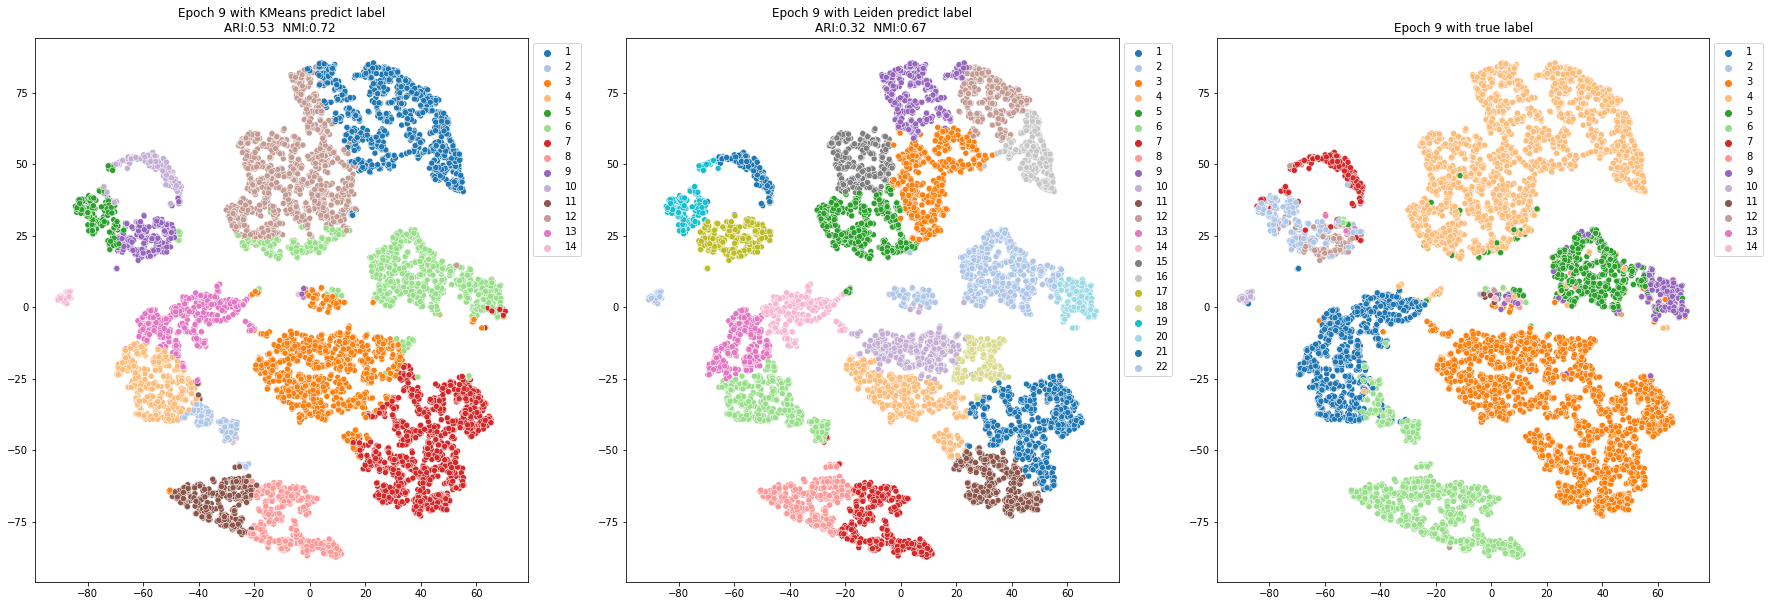

In [29]:
checkpoint = torch.load('save\sc-static-bank\checkpoint_09.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=14,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=9)

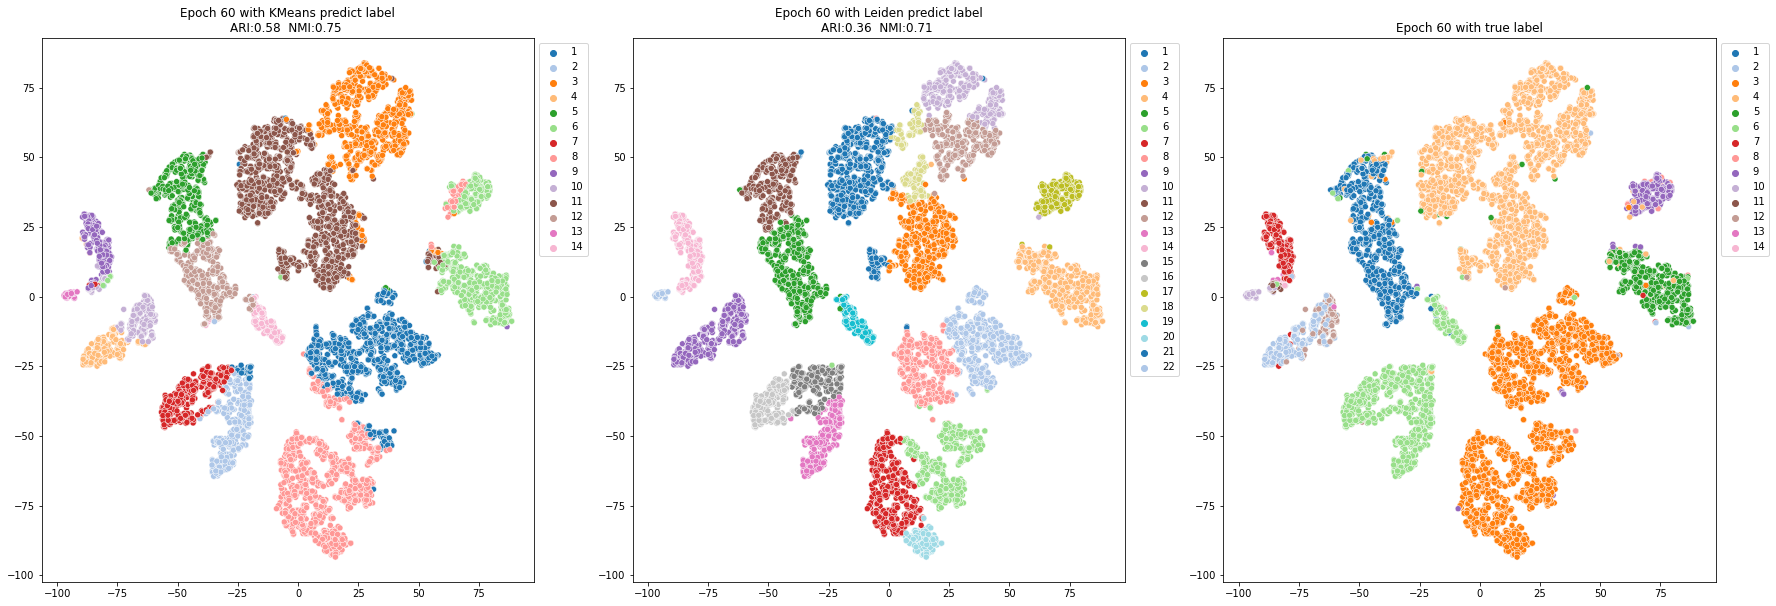

In [30]:
checkpoint = torch.load('save\sc-static-bank\checkpoint_60.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=14,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=60)

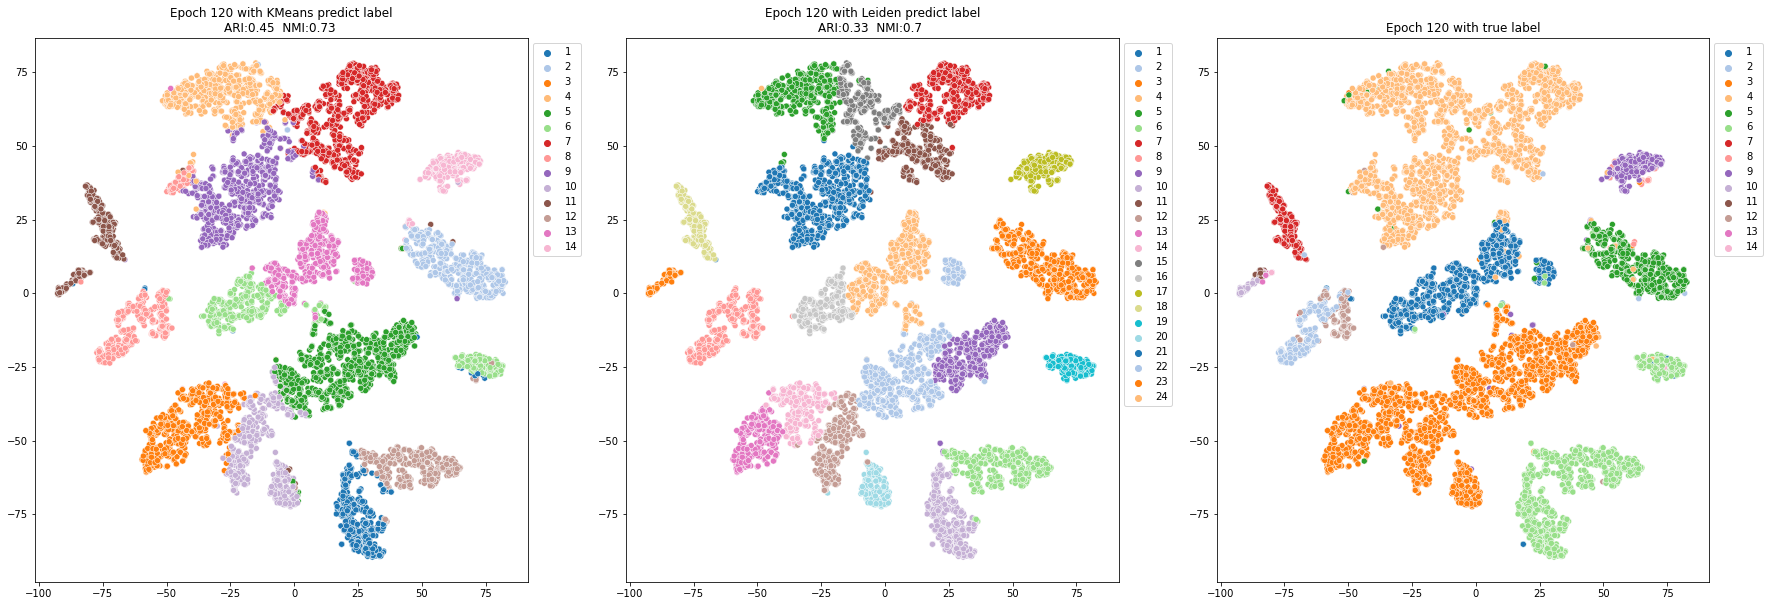

In [5]:
checkpoint = torch.load('save\sc-static-bank\checkpoint_120.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=14,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=120)

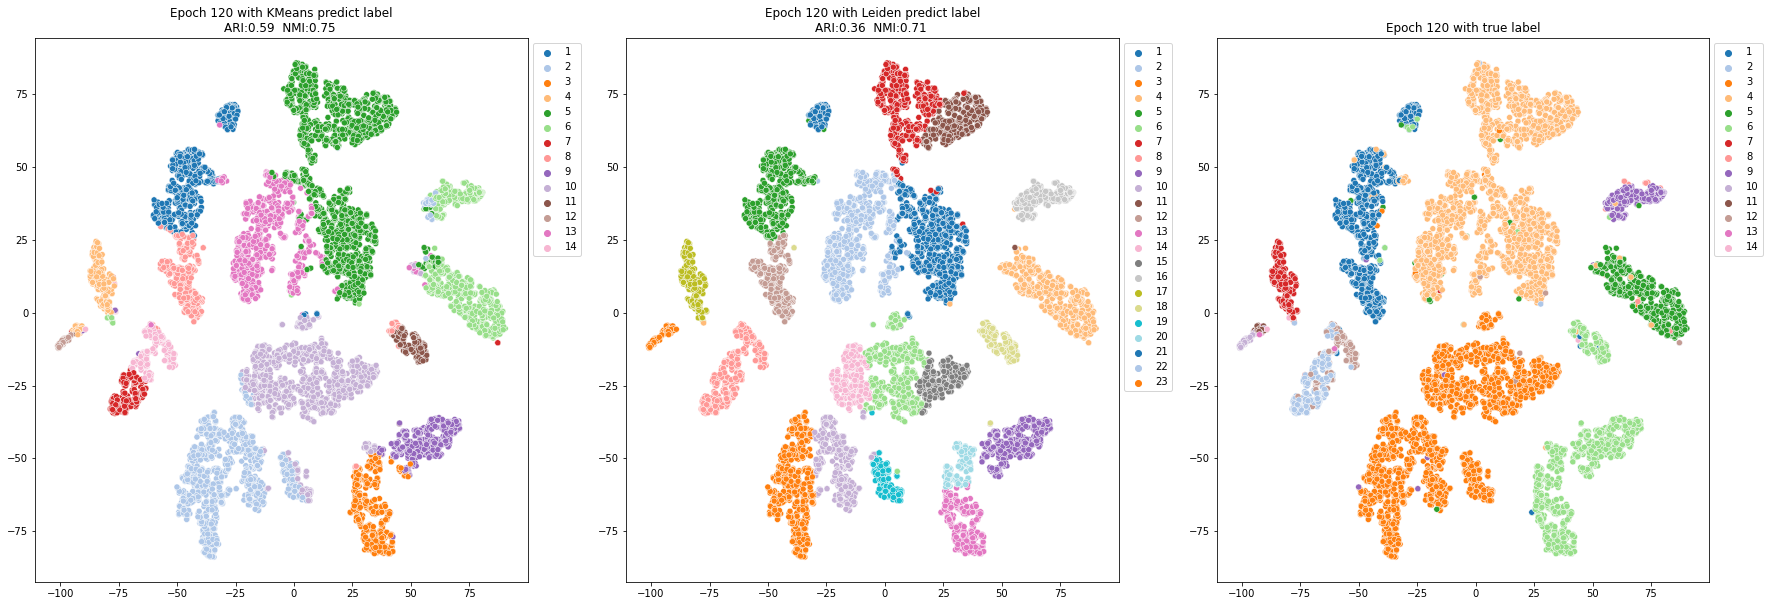

In [6]:
checkpoint = torch.load('save\sc-static-bank\checkpoint_120.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cosine=False,cluster_number=14,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=120)

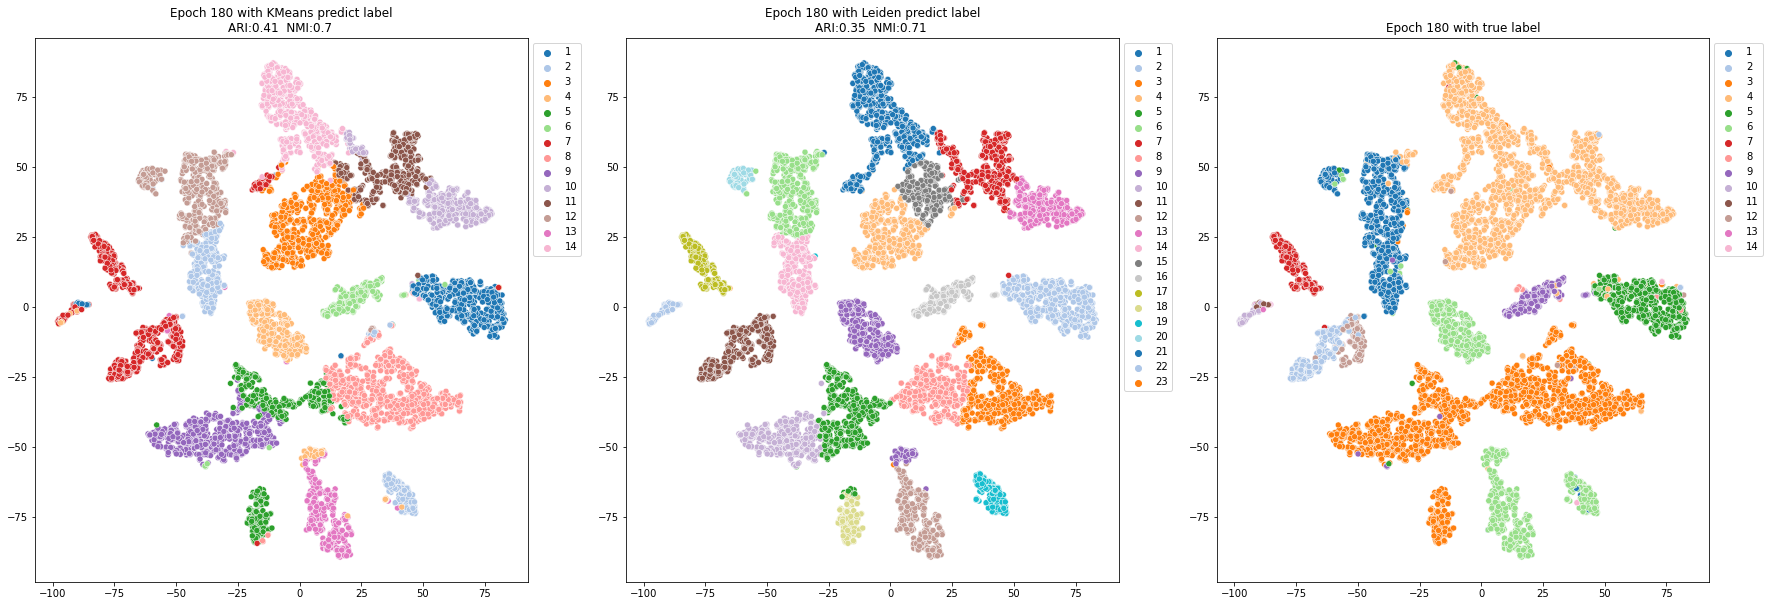

In [7]:
checkpoint = torch.load('save\sc-static-bank\checkpoint_180.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=14,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=180)

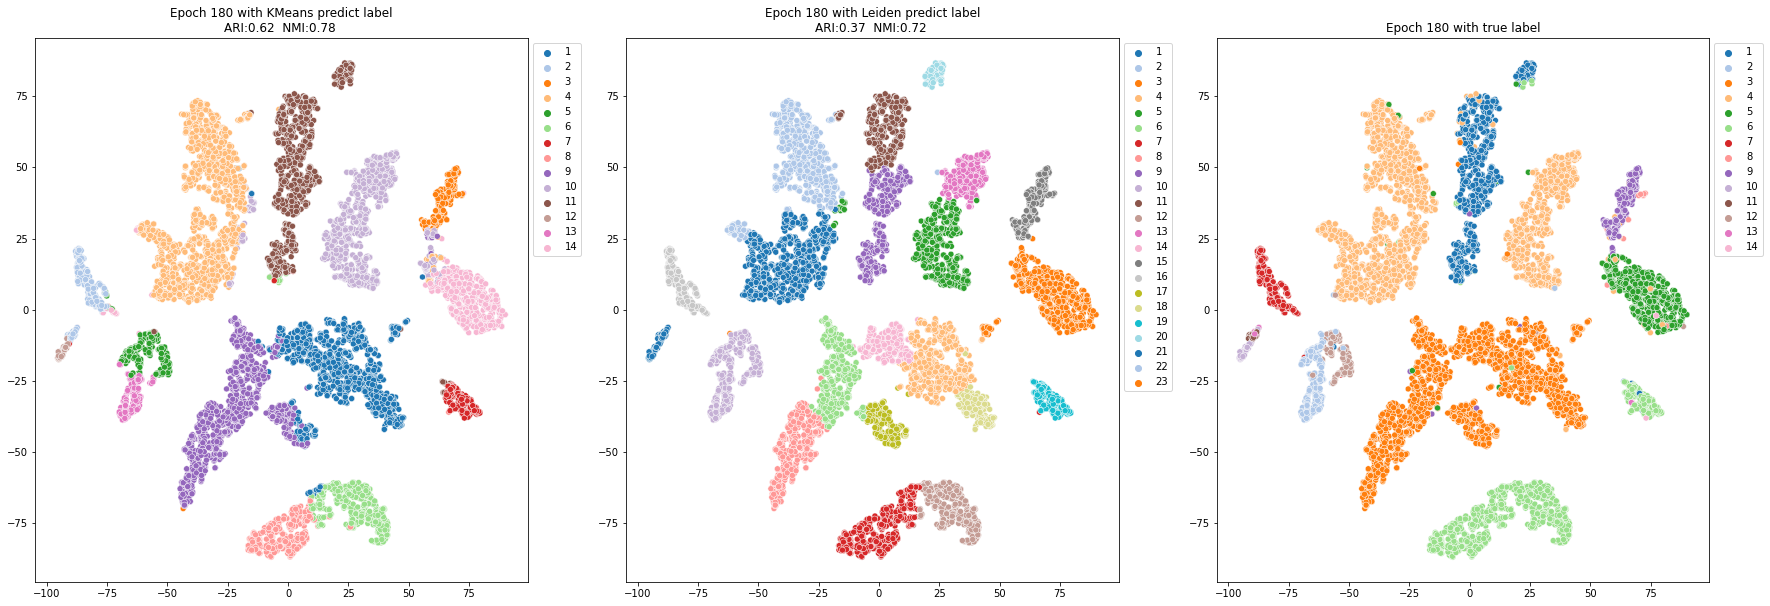

In [8]:
checkpoint = torch.load('save\sc-static-bank\checkpoint_180.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cosine=False,cluster_number=14,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=180)

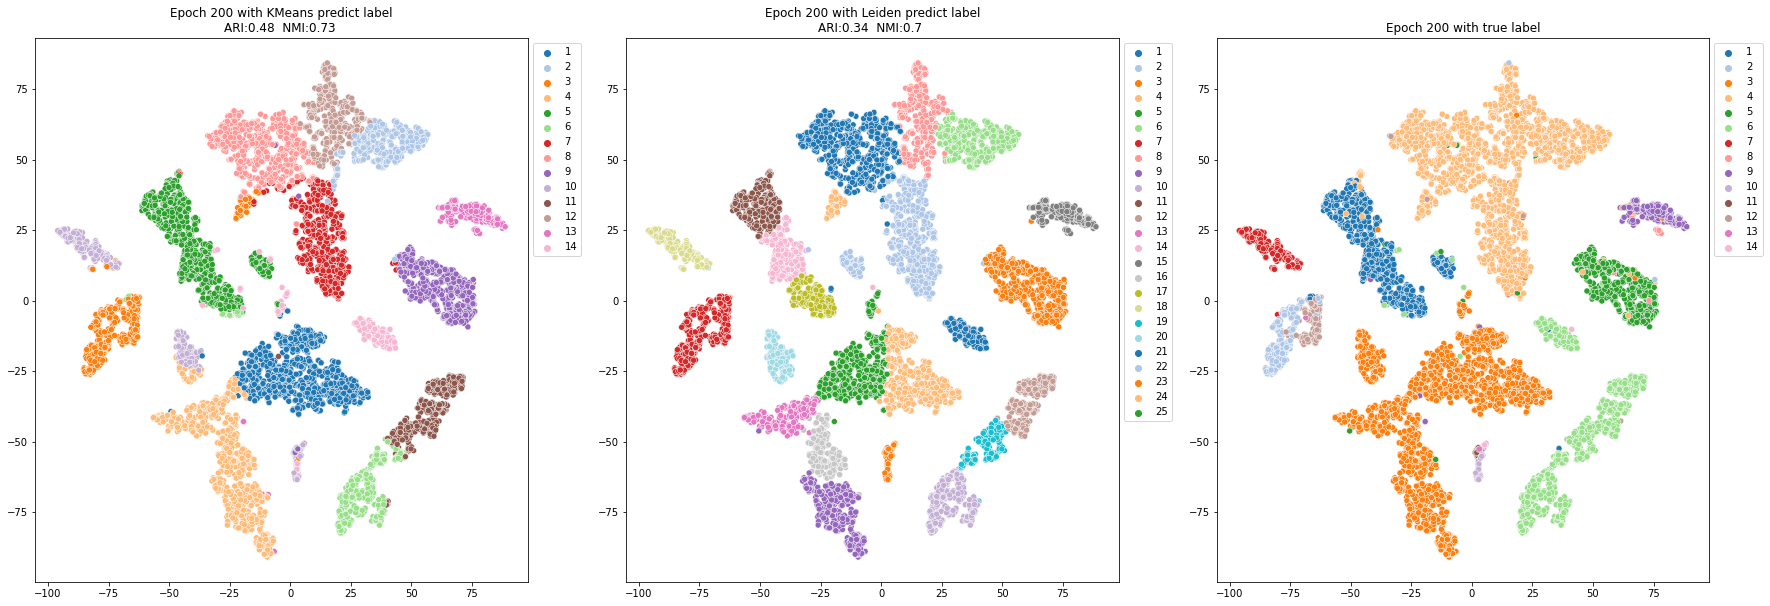

In [9]:
checkpoint = torch.load('save\sc-static-bank\checkpoint_200.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cluster_number=14,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=200)

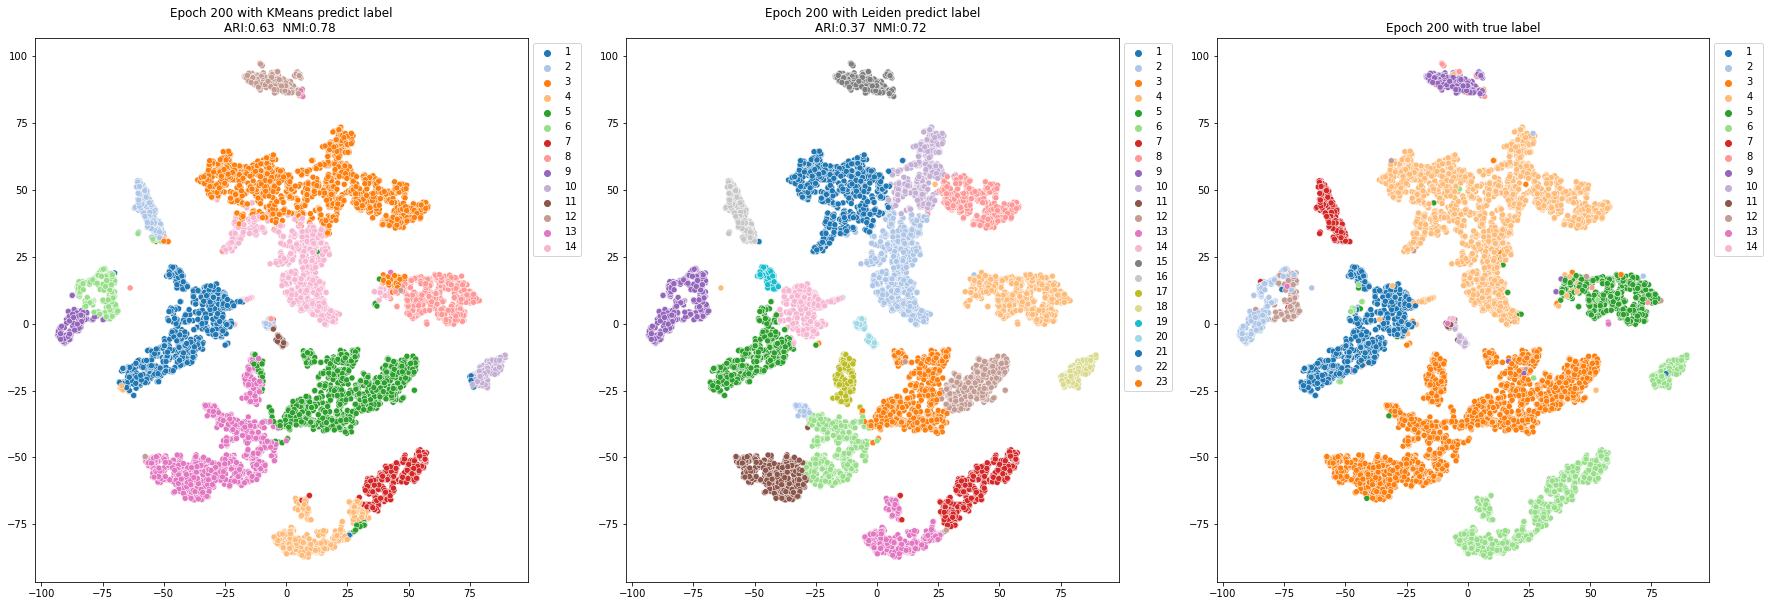

In [10]:
checkpoint = torch.load('save\sc-static-bank\checkpoint_200.tar')
model.load_state_dict(checkpoint['net'])

x=torch.tensor(x_ndarray,dtype=torch.float32).to('cuda')
embeddings=model.forward_embedding(x)
embeddings=embeddings.detach().cpu().numpy()
results=evaluation_tools.cluster_embedding(embedding=embeddings,cluster_methods=['KMeans','Leiden'],cosine=False,cluster_number=14,Y=y_ndarray.squeeze(),save_pred=True)
evaluation_tools.embedding_cluster_visualization(embeddings=embeddings,result=results,true_label=y_ndarray.squeeze(),args=args,epoch=200)